In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from PIL import Image
import csv
import cv2
import os
import sys

In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Loading Dataset

In [3]:
lines=[]

firstline = True
Train_car_images=[]
Valid_car_images=[]
Test_car_images =[]
Train_steering_angles=[]
Valid_steering_angles=[]
Test_steering_angles =[]
with open('Car Sim/Datos/driving_log.csv', 'r') as f:
    reader = csv.reader(f)
    contador = 0
    for row in reader:
        contador +=1
        if firstline:    #skip first line
            firstline = False
            continue
        steering_center = float(row[3])

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        source_path1 = row[0]
        source_path2 = row[1]
        source_path3 = row[2]
        filename1 = source_path1.split('/')[-1]
        filename2 = source_path2.split('/')[-1]
        filename3 = source_path3.split('/')[-1]
        path1 = 'Car Sim/Datos/IMG/' + filename1 
        path2 = 'Car Sim/Datos/IMG/' + filename2 
        path3 = 'Car Sim/Datos/IMG/' + filename3 
        
        img_center = np.asarray(Image.open(path1))
        img_left = np.asarray(Image.open(path2))
        img_right = np.asarray(Image.open(path3))
        if contador <= 8:
            Train_car_images.extend([img_center, img_left, img_right])
            Train_steering_angles.extend([steering_center, steering_left, steering_right])
        elif contador <=10:
            Valid_car_images.extend([img_center, img_left, img_right])
            Valid_steering_angles.extend([steering_center, steering_left, steering_right])
        else:
            Test_car_images.extend([img_center, img_left, img_right])
            Test_steering_angles.extend([steering_center, steering_left, steering_right])
            if contador == 13:
                contador = 0

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Data Augmentation (optional)

In [ ]:
tmp1 = []
tmp2 = []
for aug_image,aug_men in zip(Train_car_images,Train_steering_angles):
    tmp1.append(aug_image)
    tmp2.append(aug_men)
    tmp1.append(cv2.flip(aug_image,1))
    tmp2.append(aug_men*-1.0)
Train_car_images = tmp1
Train_steering_angles = tmp2

tmp1 = []
tmp2 = []
for aug_image,aug_men in zip(Valid_car_images,Valid_steering_angles):
    tmp1.append(aug_image)
    tmp2.append(aug_men)
    tmp1.append(cv2.flip(aug_image,1))
    tmp2.append(aug_men*-1.0)
Valid_car_images = tmp1
Valid_steering_angles = tmp2

tmp1 = []
tmp2 = []
for aug_image,aug_men in zip(Test_car_images,Test_steering_angles):
    tmp1.append(aug_image)
    tmp2.append(aug_men)
    tmp1.append(cv2.flip(aug_image,1))
    tmp2.append(aug_men*-1.0)
Test_car_images = tmp1
Test_steering_angles = tmp2
del tmp1,tmp2

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Passing to numpy arrays and creating iterators

In [4]:
x_train = np.array(Train_car_images)
del Train_car_images
x_valid = np.array(Valid_car_images)
del Valid_car_images
x_test  = np.array(Test_car_images)
del Test_car_images
y_train = np.array(Train_steering_angles)
y_valid = np.array(Valid_steering_angles)
y_test  = np.array(Test_steering_angles)
del Train_steering_angles,Valid_steering_angles,Test_steering_angles

In [5]:
Train_Samples = x_train.shape[0]
Valid_Samples = x_valid.shape[0]

In [6]:
del x_train, y_train, x_valid, y_valid

In [ ]:
from Training import create_regression_iterators
Train_bs     = 32
Inference_bs = 32
train_dataset,valid_dataset,test_dataset = create_regression_iterators((x_train, y_train),(x_valid, y_valid),
                                                                       (x_test,  y_test),T_Bs = Train_bs,
                                                                       I_Bs = Inference_bs)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Creating Model

In [ ]:
from Nets import PilotNet_model

PilotNet = PilotNet_model(Quantization = False, Errors = False,  Bs = 32)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Compile Model
PilotNet.compile(optimizer=optimizer, loss='mse')
PilotNet.summary()

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [10]:
early_stop = True
callbacks = []

# Early Stopping
# --------------
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    callbacks.append(es_callback)


In [ ]:
PilotNet.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(Train_Samples / Train_bs)),
          validation_data=valid_dataset,
          validation_steps=int(np.ceil(Valid_Samples / Train_bs)), 
          callbacks=callbacks)

In [19]:
OrigLoss = PilotNet.evaluate(test_dataset)

124/124 [==============================] - 1s 8ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Save/Load Weigths

In [18]:
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd, 'Trained Weights')
Wgt_dir = os.path.join(Wgt_dir, 'PilotNet')
Wgt_dir = os.path.join(Wgt_dir,'Weights')
PilotNet.load_weights(Wgt_dir)

# 2) Quantization 

In [10]:
from Training import create_regression_iterators
Inference_bs = 32
_,_,test_dataset = create_regression_iterators(None,None,(x_test,  y_test),T_Bs = Train_bs, I_Bs = Inference_bs)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [11]:
from Quantization_and_Errors import Check_Regression_Loss

# Showing accuracy with a heurisitc value of cuantization with no decrease in performance
Check_Regression_Loss('Pilot', test_dataset, Wgt_dir, Afrac_size = 7, Aint_size = 7, Wfrac_size = 7, Wint_size = 7);

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Activation Fractional Number of Bits

In [12]:
E1_bits      = [1,2,3,4,5,6,7]
E1_loss      = [None]*7
for index in range(0,7):
    E1_loss[index] = Check_Regression_Loss(model = 'Pilot', test_dataset = test_dataset, Wgt_dir = Wgt_dir, 
                                           Afrac_size   = E1_bits[index], Aint_size   = 7,
                                           Wfrac_size   =              7, Wint_size   = 7)

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Activation Integer Number of Bits

In [13]:
E2_bits      = [0,1,2,3,4,5,6,7]
E2_loss      = [None]*8
for index in range(0,8):
    E2_loss[index] = Check_Regression_Loss(model = 'Pilot', test_dataset = test_dataset, Wgt_dir = Wgt_dir,
                                           Afrac_size   =              7, Aint_size   = E2_bits[index],
                                           Wfrac_size   =              7, Wint_size   =              7)

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Weights Fractional Number of Bits

In [14]:
E3_bits      = [1,2,3,4,5,6,7]
E3_loss      = [None]*7
for index in range(0,7):
    E3_loss[index] = Check_Regression_Loss(model = 'Pilot', test_dataset = test_dataset, Wgt_dir = Wgt_dir,
                                           Afrac_size   =              7, Aint_size   = 7,
                                           Wfrac_size   = E3_bits[index], Wint_size   = 7)

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Weights Integer Number of Bits

In [15]:
E4_bits      = [0,1,2,3,4,5,6,7]
E4_loss      = [None]*8
for index in range(0,8):
    E4_loss[index] = Check_Regression_Loss(model = 'Pilot', test_dataset = test_dataset, Wgt_dir = Wgt_dir,
                                           Afrac_size   =              7, Aint_size   =              7,
                                           Wfrac_size   =              7, Wint_size   = E4_bits[index])

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Best Config

In [16]:
Check_Regression_Loss('Pilot', test_dataset, Wgt_dir, Afrac_size = 7, Aint_size = 0, Wfrac_size = 7, Wint_size = 0);

124/124 [==============================] - 1s 9ms/step - loss: 0.0025


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Plotting Results

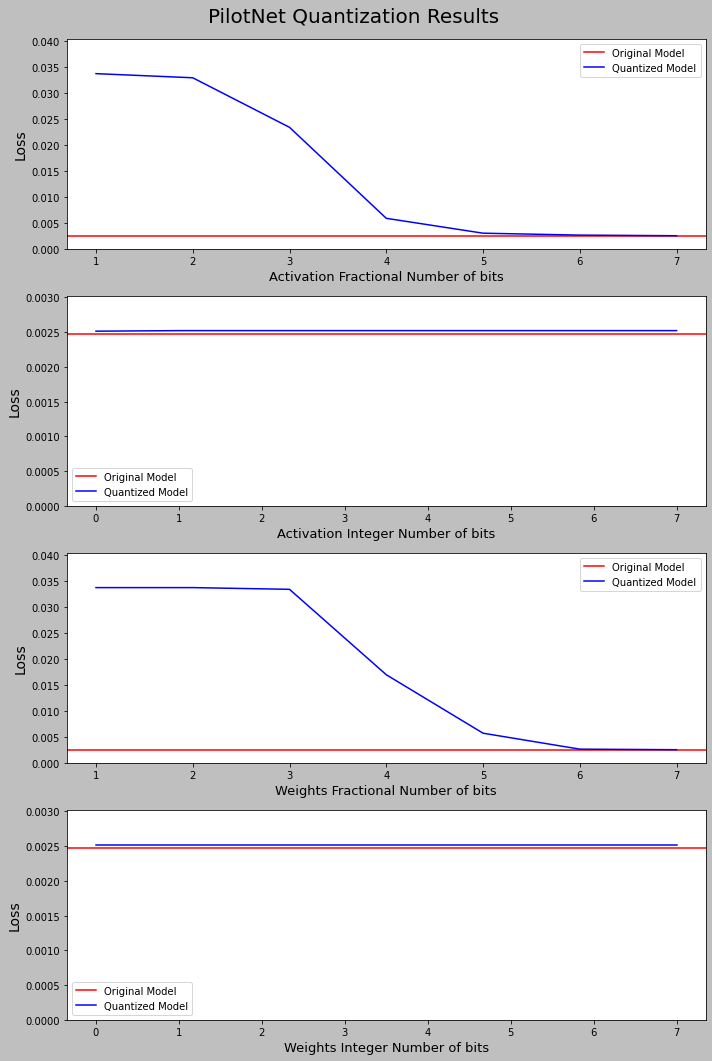

In [29]:
from Plots import Plot_4Experiments

Qbits   = [E1_bits,E2_bits,E3_bits,E4_bits]
Accs    = None
Losses  = [E1_loss,E2_loss,E3_loss,E4_loss]
xlabels = ['Activation Fractional Number of bits', 'Activation Integer Number of bits',
                       'Weights Fractional Number of bits',   'Weights Integer Number of bits' ]

Plot_4Experiments('PilotNet', Qbits, Accs, Losses, None, OrigLoss, xlabels, figsize = (10,15), save_fig = True,
                 fig_dir = 'Figures/Quantization Experiments/PilotNet/Weights/')

# 3) Buffer Simulation

In [51]:
from Training import create_regression_iterators
Inference_bs = 1
_,_,test_dataset = create_regression_iterators(None,None,(x_test,  y_test), I_Bs = Inference_bs)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Load Quantized Model

In [53]:
from Nets import PilotNet_model
from Quantization_and_Errors import Weight_Quantization

QPilotNet = PilotNet_model(Quantization = False, Errors = False,  Bs = 32)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
QPilotNet.compile(optimizer=optimizer, loss='mse')
QPilotNet.load_weights(Wgt_dir).expect_partial()
Weight_Quantization(model = QPilotNet, Frac_Bits = 7, Int_Bits = 0)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Simulate a portion of the test dataset  through the buffers 

In [54]:
from tensorflow.python.keras import backend as K
def get_all_outputs(model, input_data, learning_phase=False):
    outputs = [layer.output for layer in model.layers] # exclude Input
    layers_fn = K.function([model.input], outputs)
    return layers_fn([input_data])

In [ ]:
from Simulation import PilotNet_Sim, save_obj, load_obj
from timeit import default_timer as timer

IOBuffer_size = 72912*8

# Bufferes
IOBuffer_1 = np.zeros(IOBuffer_size,dtype=np.int8)
IOBuffer_2 = np.zeros(IOBuffer_size,dtype=np.int8)

# Diccionario de estadisticas de los buffers
duty_1 = np.zeros(IOBuffer_size,dtype=np.uint32)
duty_2 = np.zeros(IOBuffer_size,dtype=np.uint32)
                    
ciclos = 0
#from functions import save_obj, load_obj, Load_Image


iterator   = iter(test_dataset)
index      = 0
batch_size = 3953
start      = timer()
while index < batch_size:
    image = next(iterator)[0]
    acts = get_all_outputs(QPilotNet,image)
    acts = [acts[4],acts[7],acts[10],acts[13],acts[16],acts[19],acts[24],acts[27],acts[30],acts[33],acts[35]]
    if index % 2 == 0:
        ciclos += PilotNet_Sim(acts,IOBuffer_1,duty_1,IOBuffer_2,duty_2,word_size = 8, frac_size = 7)
    else:
        ciclos += PilotNet_Sim(acts,IOBuffer_2,duty_2,IOBuffer_1,duty_1,word_size = 8, frac_size = 7)
    index = index + 1
    if index % 50 == 0:
        save_obj(duty_1,'Stats/PilotNet/Weights/duty_B1')
        save_obj(duty_2,'Stats/PilotNet/Weights/duty_B2')
        save_obj(ciclos,'Stats/PilotNet/Weights/ciclos')
        print('imagenes procesadas:',index,' tiempo:',timer()-start,'ciclos: ',ciclos)

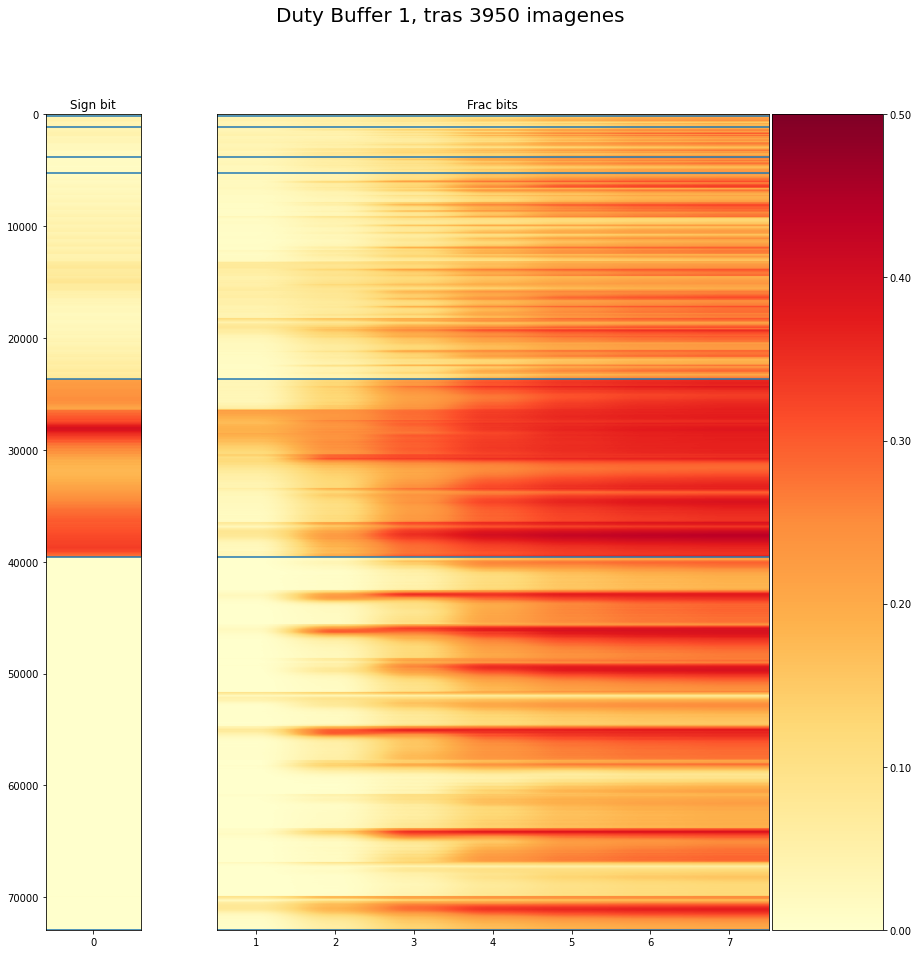

In [79]:
from Plots import plot_duty
plot_duty(duty_1, ciclos, 'Duty Buffer 1, tras 3950 imagenes', low=0, high=72912, mode = 'Duty',
          figsize = (15,15), bits_dist=[1,7], threshold = None,
          save_fig = True, fig_dir='Figures/Buffer Heatmaps/PilotNet/Weights/Duty Buffer 1',
          sections_boundaries = [100,1164,3840,5280,23688,39600,72912])

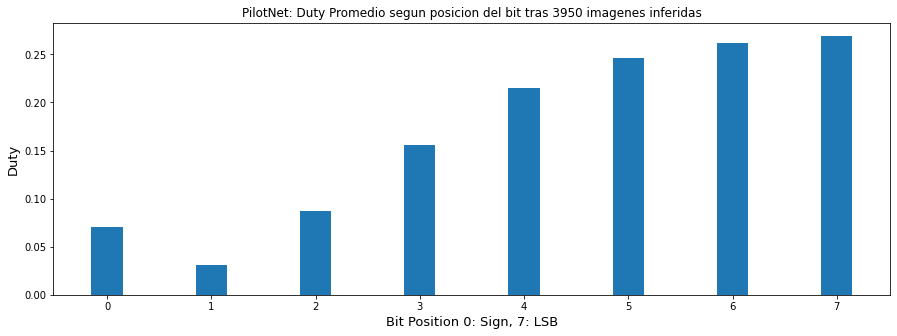

In [77]:
import matplotlib.pyplot as plt

data   = load_obj('Stats/PilotNet/Weights/duty_B1').astype(np.uint64)
ciclos = load_obj('Stats/PilotNet/Weights/ciclos').astype(np.uint64)
data   = np.reshape(data,(72912,8))
data   = np.sum(data,axis=0)/(ciclos*72912)
data   = np.reshape(data,(1,-1))

plt.figure(figsize=(15,5))
plt.title('PilotNet: Duty Promedio segun posicion del bit tras 3950 imagenes inferidas')
fig = plt.bar(['0','1','2','3','4','5','6','7'],data[0],0.3)
plt.xlabel('Bit Position 0: Sign, 7: LSB',fontsize=13)
plt.ylabel('Duty',fontsize=13)
plt.savefig('Figures/Buffer Heatmaps/PilotNet/Weights/Duty per bit position')

# 4) Error Injection

In [8]:
from Training import create_regression_iterators


Inference_bs = 32
_,_,test_dataset = create_regression_iterators(None,None,(x_test,  y_test), I_Bs = Inference_bs)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Checking the big sections

In [ ]:
from copy import deepcopy
from Quantization_and_Errors import Check_Regression_Loss
from Simulation import save_obj, load_obj
from timeit import default_timer as timer

Start_from_zero = True

if Start_from_zero:
    tmp_dict = {0.001:[],0.01:[],0.05:[],0.1:[],0.2:[],0.3:[]}  #Portions to test in each section
    
    tmp_dict = {'Buffer 1': {'Addresses 50-1164': deepcopy(tmp_dict),
                             'Addresses 1164-3840': deepcopy(tmp_dict),
                             'Addresses 3840-23688': deepcopy(tmp_dict),
                             'Addresses 23688-39600': deepcopy(tmp_dict)},              
                'Buffer 2': {'Addresses 100-1164': deepcopy(tmp_dict),
                             'Addresses 1164-5280': deepcopy(tmp_dict),
                             'Addresses 5280-72912': deepcopy(tmp_dict)}}
    Loss     = {'1st bit':deepcopy(tmp_dict), '2nd bit':deepcopy(tmp_dict)}
else:
    Loss     = load_obj('Errors/PilotNet/Weights/Loss')


Mapping   = {'Buffer 1':[True,False,True,False,True,False,True,False,True,False], #Buffer_Error_Mask
             'Buffer 2':[False,True,False,True,False,True,False,True,False,True], #Buffer_Error_Mask
             'Addresses 50-1164'    : (range(50,1164)    ,1114),   #Range and Len of each section
             'Addresses 100-1164'   : (range(100,1164)   ,1064),
             'Addresses 1164-3840'  : (range(1164,3840)  ,2676),
             'Addresses 1164-5280'  : (range(1164,5280)  ,4116),
             'Addresses 3840-23688' : (range(3840,23688) ,19848),
             'Addresses 23688-39600': (range(23688,39600),15912),
             'Addresses 5280-72912' : (range(5280,72912) ,67632),
             '1st bit': ['1xxxxxxx'], # mask of the error
             '2nd bit': ['x1xxxxxx']}

Num_of_samples = 200
start = timer()
for bit_loc in Loss:
    for Buffer in Loss[bit_loc]:
        for section in Loss[bit_loc][Buffer][section]:
            for Enumber in Loss[bit_loc][Buffer][section]:
                for index in range(0,Num_of_samples):
                    number_of_errors = np.ceil(Enumber*Mapping[section][1]).astype(int)
                    loss = Check_Regression_Loss('Pilot', test_dataset, Wgt_dir, Afrac_size = 7, Aint_size = 0,
                                                  Wfrac_size = 7, Wint_size = 0, Bs=Inference_bs, verbose = 0, 
                                                  locations = np.random.choice(Mapping[section][0],number_of_errors,False), 
                                                  errors = Mapping[bit_loc]*number_of_errors,
                                                  Layer_Error_mask = Mapping[Buffer])
                    Loss[bit_loc][Buffer][section][Enumber].append(loss)
            print(bit_loc+', '+Buffer+', '+section+' completada en: ',timer()-start)
            save_obj(Loss,'Errors/PilotNet/Weights/Loss')

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Checking the small sections

In [9]:
from copy import deepcopy
from Quantization_and_Errors import Check_Regression_Loss
from Simulation import save_obj, load_obj
from timeit import default_timer as timer

Start_from_zero = True

if Start_from_zero:
    tmp_dict = {1:[],4:[],16:[],32:[],64:[]}   #Number of faulty addresses to test
    
    tmp_dict = {'Buffer 1': {'Addresses 0-100': deepcopy(tmp_dict)},              
                'Buffer 2': {'Addresses 0-100': deepcopy(tmp_dict)}}
    Loss     = {'1st bit':deepcopy(tmp_dict), '2nd bit':deepcopy(tmp_dict)}
else:
    Loss     = load_obj('Errors/PilotNet/Weights/Loss_Low_Address')

Mapping   = {'Buffer 1':[True,False,True,False,True,False,True,False,True,False], #Buffer_Error_Mask
             'Buffer 2':[False,True,False,True,False,True,False,True,False,True], #Buffer_Error_Mask
             'Addresses 0-100'    : (range(0,100) ,100),   #Range and Len of each section
             '1st bit': ['1xxxxxxx'], # mask of the error
             '2nd bit': ['x1xxxxxx']}

Num_of_samples = 200
for bit_loc in Loss:
    for Buffer in Loss[bit_loc]:
        for section in Loss[bit_loc][Buffer]:
            for Enumber in Loss[bit_loc][Buffer][section]:
                for index in range(0,Num_of_samples):
                    number_of_errors = Enumber
                    loss = Check_Regression_Loss('Pilot', test_dataset, Wgt_dir, Afrac_size = 7, Aint_size = 0,
                                     Wfrac_size = 7, Wint_size = 0, Bs=Inference_bs, verbose = 0, 
                                     locations = np.random.choice(Mapping[section][0],number_of_errors,False), 
                                     errors = Mapping[bit_loc]*number_of_errors,
                                     Layer_Error_mask = Mapping[Buffer])
                    Loss[bit_loc][Buffer][section][Enumber].append(loss)
            print(bit_loc+', '+Buffer+', '+section+' completada en: ',timer()-start)
            save_obj(Loss,'Errors/PilotNet/Weights/Loss_Low_Addresses')

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Plots

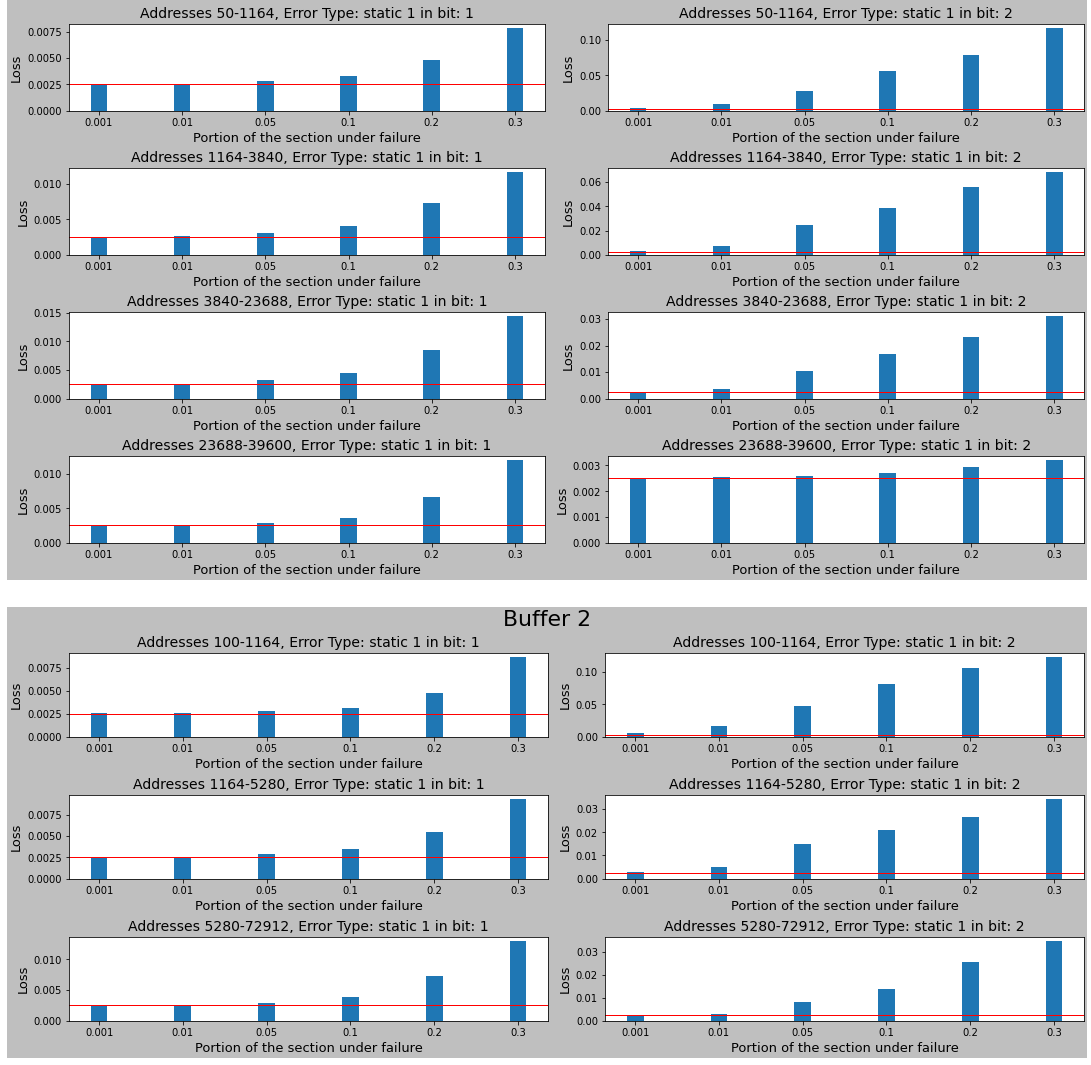

In [208]:
from Plots import Plot_Errors
DataDicts = load_obj('Errors/PilotNet/Weights/Loss')
Sections = [['Addresses 50-1164',  'Addresses 1164-3840', 'Addresses 3840-23688', 'Addresses 23688-39600'],
            ['Addresses 100-1164', 'Addresses 1164-5280', 'Addresses 5280-72912']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.0025, figsize=(15,15), save_fig=False,
            xlabel  = 'Portion of the section under failure', BoxPlot = False,  Scaled_max_value= None,
            fig_dir = 'Figures/Errors/PilotNet/Weights/Effect of errors by section and number of faulty addresses')

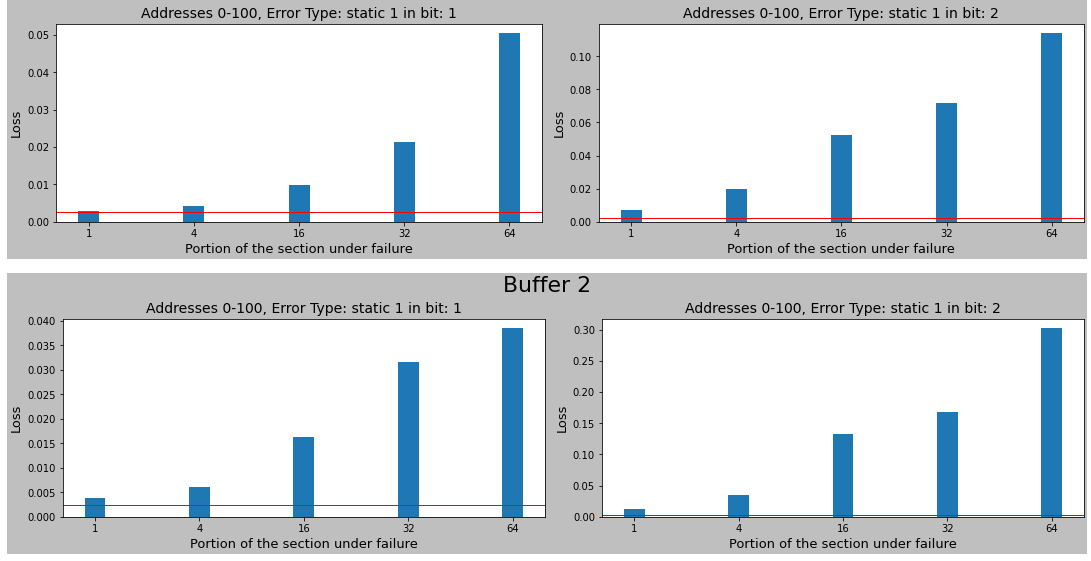

In [211]:
from Plots import Plot_Errors
DataDicts = load_obj('Errors/PilotNet/Weights/Loss_in_Low_Addresses')
Sections = [['Addresses 0-100'],
            ['Addresses 0-100']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.0025, figsize=(15,8), save_fig=False,
            xlabel  = 'Portion of the section under failure', BoxPlot=False,  Scaled_max_value= None,
            fig_dir = 'Figures/Errors/PilotNet/Weights/Effect of errors by section and number of faulty addresses')